# Quora Duplicate Question detection:
    ** TEAM ACN: **
    ** Course Instructor: Dr.Vineet Gandhi **
    ** Mentor : Apurva Jadhav **

  

    *   Ayush Kumar Rai   - 2020201087
    *   P.Chaitanya Kumar - 2020201012 
    *   Neha Agarwal      - 2020201095 








## Objective:
    1.In this project we’ll explore different kinds of Models that efficiently 
    classifies which pair of questions on quora are duplicate and which are not. 
    2.In a way we are trying to mimic human judgement with the help of machine learning.
    3.We need to identify which questions asked on Quora are duplicates of questions that have already been asked.
    4.This will be useful to provide answers to questions that have already been answered.



### Necessary Imports:

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,precision_score,accuracy_score
from sklearn.svm import SVC
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Exploratory Data Analysis

### Overview of the Dataset:
 Data set was taken from Kaggle datasets


1.   Total samples were present in questions.csv
2.   questions.csv contains 5 columns namely `qid1`, `qid2`, `question1`, `question2`, `is_duplicate`.
3. Number of samples in the data set are 404,351 as seen in the output of the code below.



In [ ]:
df = pd.read_csv("drive/My Drive/questions.csv")


print("Number of data points:",df.shape[0])

Number of data points: 404351


### Observing the samples:


1.   qid1,qid2,id,is_duplicate are numerical valuess and the actual questions question1 and question2 are text data. So, we need some feature engineering to convert them to some vector representation.
2.   `is_duplicate` contains two classes `0` for `not duplicate` (-ve class) and `1` for `duplicate`(+ ve class).
3. From the observations it is clear that it is a binary class classification problem.
4. We need to predict the i_duplicate value.



In [ ]:
df.head()

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]

In [ ]:
df_backup=df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### NULL values:


1.   From the above observation it is clear that there are null values in the `question1` and `question2` text data.
2.   So we need to eliminate the null values before preprocessing the data and feature engineering.



### Duplicate counts:
   In the below o/p we can see that there approximately 61.8% of `is_duplicate=0` values and the remaining of the opposite value.

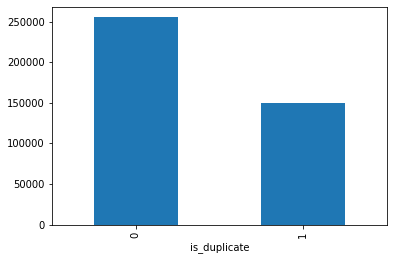

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()


In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 789801

Number of unique questions that appear more than one time: 13698 (1.7343609339567814%)

Max number of times a single question is repeated: 50



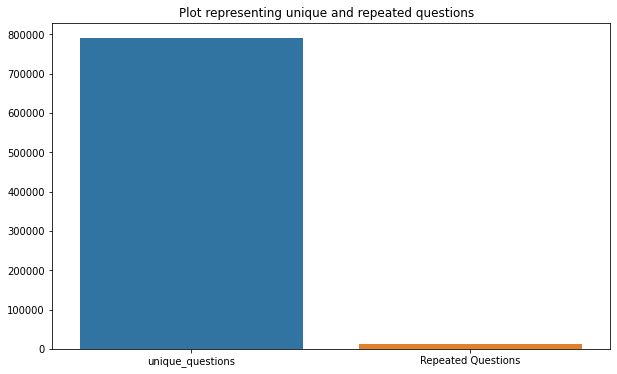

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x = x,y = y)
plt.show()

In [ ]:

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates.shape[0] - df.shape[0]))

Number of duplicate questions -3


Maximum number of times a single question is repeated: 50



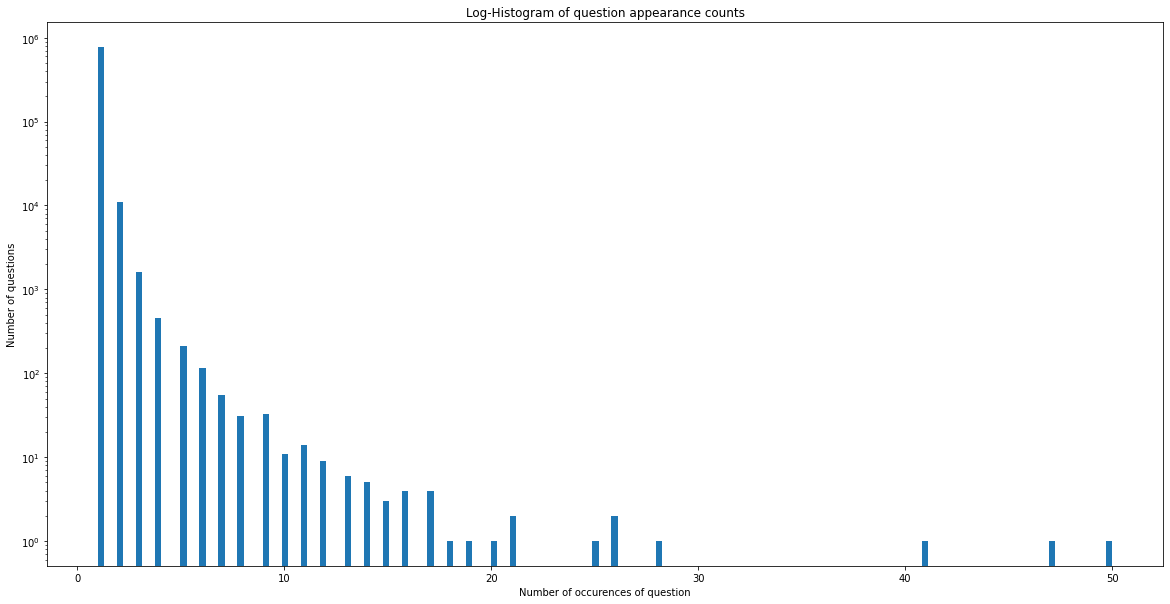

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## Data cleaning and preprocessing:

#### Dropping nan containing samples

In [ ]:
df = df.dropna(thresh=6)

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True) 
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

#### Storing target value in variable `target`

In [ ]:
target=df['is_duplicate']
with open('label', 'wb') as fp:
    pickle.dump(target.values, fp)

In [ ]:
len(target)

404348

In [ ]:
## Getting the stop words from the engish. There is inbuilt feature to extract that

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):

    # specifictext


    phrase = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", phrase)
    phrase = re.sub(r",", " ", phrase)
    phrase = re.sub(r"\.", " ", phrase)
    phrase = re.sub(r"!", " ", phrase)
    phrase = re.sub(r"\(", " ( ", phrase)
    phrase = re.sub(r"\)", " ) ", phrase)
    phrase = re.sub(r"\?", " ", phrase)
    phrase = re.sub(r"\s{2,}", " ", phrase)

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub("\'ve", " have ", phrase)
    phrase = re.sub(" whats ", " what is ", phrase, flags=re.IGNORECASE)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub("n't", " not ", phrase)
    phrase = re.sub("i'm", "i am", phrase, flags=re.IGNORECASE)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub("e\.g\.", " eg ", phrase, flags=re.IGNORECASE)
    phrase = re.sub("b\.g\.", " bg ", phrase, flags=re.IGNORECASE)
    phrase = re.sub("e-mail", " email ", phrase, flags=re.IGNORECASE)
    phrase = re.sub("(\d+)(kK)", " \g<1>000 ", phrase)
    phrase = re.sub("\(s\)", " ", phrase, flags=re.IGNORECASE)
    phrase = re.sub("[c-fC-F]\:\/", " disk ", phrase)
    phrase = re.sub('(?<=[0-9])\,(?=[0-9])', "", phrase)  ## removing comma between numbers like 15,000...
    phrase = re.sub('\$', " dollar ", phrase)
    phrase = re.sub('\%', " percent ", phrase)
    phrase = re.sub('\&', " and ", phrase)

    phrase = re.sub("(?<=[0-9])rs ", " rs ", phrase, flags=re.IGNORECASE)
    phrase = re.sub(" rs(?=[0-9])", " rs ", phrase, flags=re.IGNORECASE)

    return phrase

### Preprocessing questions

In [ ]:
preprocessed_question1 = []
preprocessed_question2 = []

In [ ]:
import time 
start=time.time()

# tqdm is for printing the status bar
try:
  for sentence in (df['question1'].values):
      encoded_string = sentence.encode("ascii", "ignore")
      sentence = encoded_string.decode()
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
      sentence = decontracted(sentence)
      sentence = re.sub("\S*\d\S*", "", sentence).strip()
      sentence = re.sub('[^A-Za-z]+', ' ', sentence)
      #------------------------------------------------------------------------
      #https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python    #------------------------------------------------------------------------
      sentence =re.sub(r'\b\w\b', ' ', sentence)# To remove single letter words
      sentence=re.sub(r'\s{2,}', ' ', sentence).strip()

      #print(sentence)
      #------------------------------------------------------------------------
      # https://gist.github.com/sebleier/554280
      sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
      preprocessed_question1.append(sentence.strip())

except TypeError:
  print(sentence)

print(f'time taken for completion of data cleaning is {time.time()-start}')

time taken for completion of data cleaning is 126.30787110328674


In [ ]:
import time 
start=time.time()
try:
  preprocessed_question2 = []
  # tqdm is for printing the status bar
  for sentence in (df['question2'].values):
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
      sentence = decontracted(sentence)
      sentence = re.sub("\S*\d\S*", "", sentence).strip()
      sentence = re.sub('[^A-Za-z]+', ' ', sentence)
      #------------------------------------------------------------------------
      #https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python    #------------------------------------------------------------------------
      sentence =re.sub(r'\b\w\b', ' ', sentence)# To remove single letter words
      sentence=re.sub(r'\s{2,}', ' ', sentence).strip()

      #print(sentence)
      #------------------------------------------------------------------------
      # https://gist.github.com/sebleier/554280
      sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
      preprocessed_question2.append(sentence.strip())

except TypeError:
  print(sentence)

print(f'time taken for completion of data cleaning is {time.time()-start}')

time taken for completion of data cleaning is 124.89616179466248


#### `Dumping and loading from pickel files` 

In [ ]:
with open('question1_cleaned', 'wb') as fp:
    pickle.dump(preprocessed_question1, fp)

In [ ]:
with open('question2_cleaned', 'wb') as fp:
    pickle.dump(preprocessed_question2, fp)

In [ ]:
file=open('question1_cleaned','rb')
preprocessed_question1=pickle.load(file)

In [ ]:
file=open('question2_cleaned','rb')
preprocessed_question2=pickle.load(file)

In [ ]:
file=open('label','rb')
labels=pickle.load(file)

In [ ]:
len(preprocessed_question1)

404348

In [ ]:
len(preprocessed_question2)

404348

In [ ]:
labels=target.values 

In [ ]:
len(labels)

404348

In [ ]:
labels

array([0, 0, 0, ..., 0, 0, 0])

# Linear Models:

## Logistic regression on `unigrams`.

    In the paper they clearly mentioned that they used
    L2 regularisation and the alpha is set to 0.00001 and 20 iterations

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

#### Unigrams
    In this we are creating word unigrams using  
    tf-idf  vectorizer. we can also use counttf-idf vectorizer for the same

In [ ]:
tfv_q1 =TfidfVectorizer(analyzer='word',ngram_range = (1,1))

In [ ]:
from copy import deepcopy

tfv_q2=deepcopy(tfv_q1)

In [ ]:
question1 = tfv_q1.fit_transform(preprocessed_question1)
question2 = tfv_q2.fit_transform(preprocessed_question2)

In [ ]:
labels=target.values
X = scipy.sparse.hstack((question1,question2))
y = labels

In [ ]:
X

<404348x121155 sparse matrix of type '<class 'numpy.float64'>'
	with 4211977 stored elements in COOrdinate format>

In [ ]:
type(y)

numpy.ndarray

#### Splitting the X and y to train valid and test 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
with open('X_train_unigram', 'wb') as fp:
    pickle.dump(X_train, fp)


with open('X_valid_unigram', 'wb') as fp:
    pickle.dump(X_valid, fp)

with open('X_test_unigram', 'wb') as fp:
    pickle.dump(X_test, fp)


In [ ]:
with open('y_train_unigram', 'wb') as fp:
    pickle.dump(y_train, fp)


with open('y_valid_unigram', 'wb') as fp:
    pickle.dump(y_valid, fp)

with open('y_test_unigram', 'wb') as fp:
    pickle.dump(y_test, fp)


In [ ]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [ ]:
X_train.shape

(291130, 121155)

In [ ]:
X_train[0].shape

(1, 121155)

### Defining the model with the above mentioned parameters

In [ ]:
clf = SGDClassifier(loss='log',penalty='l2',alpha=0.00001,max_iter=20,random_state=42)
clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=20,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
clf.predict(X_train)

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
clf.score(X_train,y_train)

0.7715762717686258

In [ ]:
clf.score(X_valid, y_valid)

0.7522910569775909

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7551131445529863

#### `F1-Score`

In [ ]:

f1_score(y_test, y_pred, average='weighted')


0.7444847868367008

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7512260447619259

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7551131445529863

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82     25696
           1       0.73      0.53      0.61     14739

    accuracy                           0.76     40435
   macro avg       0.75      0.71      0.72     40435
weighted avg       0.75      0.76      0.74     40435



#### Observations:
    As stated in the paper accuracy is 75.55 on the test data for
    alpha=0.00001 and max_iteration=20
    In the paper on unigrams it was given that the accuracy_score on unigrams if 75.4 and we got 75.55 which are similar.
    But are getting higher f1-score compared to the model i.e in the paper it was given for unigrams the f1-score is 63.8 but we are getting around 74.33

## Logistic Regression on `Bigrams`

### Bigrams
    In this we are creating word bigrams  using  
    tf-idf  vectorizer. we can also use counttf-idf vectorizer for the same

    Reference : https://hub.packtpub.com/use-tensorflow-and-nlp-to-detect-duplicate-quora-questions-tutorial/

In [ ]:
tfv_q1 =TfidfVectorizer(analyzer='word',ngram_range = (1,2))

In [ ]:
from copy import deepcopy

tfv_q2=deepcopy(tfv_q1)

In [ ]:
question1 = tfv_q1.fit_transform(preprocessed_question1)
question2 = tfv_q2.fit_transform(preprocessed_question2)

In [ ]:
labels=target.values
X = scipy.sparse.hstack((question1,question2))
y = labels

In [ ]:
X

<404348x1623453 sparse matrix of type '<class 'numpy.float64'>'
	with 7722396 stored elements in COOrdinate format>

In [ ]:
type(y)

numpy.ndarray

#### Splitting the X and y to train valid and test 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
with open('X_train_bigram', 'wb') as fp:
    pickle.dump(X_train, fp)


with open('X_valid_bigram', 'wb') as fp:
    pickle.dump(X_valid, fp)

with open('X_test_bigram', 'wb') as fp:
    pickle.dump(X_test, fp)


In [ ]:
with open('y_train_bigram', 'wb') as fp:
    pickle.dump(y_train, fp)


with open('y_valid_bigram', 'wb') as fp:
    pickle.dump(y_valid, fp)

with open('y_test_bigram', 'wb') as fp:
    pickle.dump(y_test, fp)


In [ ]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [ ]:
X_train[0].shape

(1, 1623453)

In [ ]:
X_train.shape

(291130, 1623453)

### Defining the model with the above mentioned parameters

In [ ]:
clf = SGDClassifier(loss='log',penalty='l2',alpha=0.00001,max_iter=20,random_state=42)
clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=20,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
clf.predict(X_train)

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
clf.score(X_train,y_train)

0.8193281351973345

In [ ]:
clf.score(X_valid, y_valid)

0.7773381146696344

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7796463459873871

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7673573819767661

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7821746156397654

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7796463459873871

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84     25696
           1       0.80      0.53      0.64     14739

    accuracy                           0.78     40435
   macro avg       0.79      0.73      0.74     40435
weighted avg       0.78      0.78      0.77     40435



#### Observations:

    For alpha=0.00001 and max_iteration=20
    In the paper on bigrams it was given that the accuracy_score on unigrams if 79.5 but we got 77.9  which is tad lower accuracy

## Logistic Regression on `Trigrams`

### Trigrams
    In this we are creating word Trigrams using  
    tf-idf  vectorizer. we can also use counttf-idf vectorizer for the same

In [ ]:
tfv_q1 =TfidfVectorizer(analyzer='word',ngram_range = (1,3))

In [ ]:
from copy import deepcopy

tfv_q2=deepcopy(tfv_q1)

In [ ]:
question1 = tfv_q1.fit_transform(preprocessed_question1)
question2 = tfv_q2.fit_transform(preprocessed_question2)

In [ ]:
labels=target.values
X = scipy.sparse.hstack((question1,question2))
y = labels

In [ ]:
X

<404348x3436512 sparse matrix of type '<class 'numpy.float64'>'
	with 10447142 stored elements in COOrdinate format>

#### Splitting the X and y to train valid and test 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
type(y)

numpy.ndarray

In [ ]:
X_train.shape

(291130, 3436512)

In [ ]:
X_train[0].shape

(1, 3436512)

In [ ]:
with open('X_train_trigram', 'wb') as fp:
    pickle.dump(X_train, fp)


with open('X_valid_trigram', 'wb') as fp:
    pickle.dump(X_valid, fp)

with open('X_test_trigram', 'wb') as fp:
    pickle.dump(X_test, fp)


In [ ]:
with open('y_train_trigram', 'wb') as fp:
    pickle.dump(y_train, fp)


with open('y_valid_trigram', 'wb') as fp:
    pickle.dump(y_valid, fp)

with open('y_test_trigram', 'wb') as fp:
    pickle.dump(y_test, fp)


### Defining the model with the above mentioned parameters

In [ ]:
clf = SGDClassifier(loss='log',penalty='l2',alpha=0.00001,max_iter=20,random_state=42,learning_rate='optimal').fit(X, y)
clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=20,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:

clf.predict(X_train)

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
clf.score(X_train,y_train)

0.826792154707519

In [ ]:
clf.score(X_valid, y_valid)

0.7790280697415606

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
clf.score(X_test, y_test)

0.7823667614690244

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7687910647025297

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7876955827828678

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7823667614690244

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.93      0.84     25696
           1       0.81      0.52      0.64     14739

    accuracy                           0.78     40435
   macro avg       0.79      0.73      0.74     40435
weighted avg       0.79      0.78      0.77     40435



#### Observations:

    For alpha=0.00001 and max_iteration=20
    In the paper on trigrams it was given that the accuracy_score on trigrams if 80.8 but we got 78.7 which is tad lower accuracy and only a little bit
    higher than bigrams. So, trigrams is not as efficient as bigrams

    F1-score = 76.8 which is higher compared to the papers f1-score of 71.8

## Experiments on Trigrams with Logistic regression

### Effect of varying the regularisation parameter on the trigram model

In [ ]:
alpha=[0.1,0.01,0.001,0.0001,0.00001,0.000001]

validation_accuracies=[]
F1_scores=[]

In [ ]:
for i in alpha:
  clf = SGDClassifier(loss='log',penalty='l2',alpha=i,max_iter=20,random_state=42,learning_rate='optimal').fit(X, y)
  clf.fit(X_train, y_train)
  val_score=clf.score(X_valid, y_valid)
  y_pred=clf.predict(X_valid)
  f_score=f1_score(y_valid, y_pred, average='weighted')
  validation_accuracies.append(val_score*100)
  F1_scores.append(f_score*100)

  



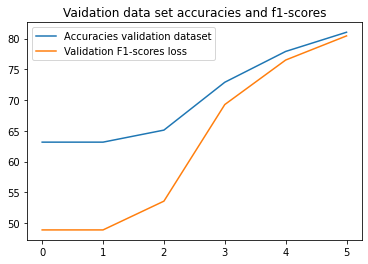

In [ ]:
plt.plot(validation_accuracies, label='Accuracies validation dataset')
plt.plot(F1_scores, label='Validation F1-scores loss')
plt.title('Vaidation data set accuracies and f1-scores')
plt.legend();

In [ ]:
from prettytable import PrettyTable
z = PrettyTable()

In [ ]:
z.field_names = ["Regularization weight", "Validation Set Accuracy%", "F-Scores on validation dataset"]
z.add_row([alpha[0],validation_accuracies[0] ,F1_scores[0]])
z.add_row([alpha[1],validation_accuracies[1] ,F1_scores[1]])
z.add_row([alpha[2],validation_accuracies[2] ,F1_scores[2]])
z.add_row([alpha[3],validation_accuracies[3] ,F1_scores[3]])
z.add_row([alpha[4],validation_accuracies[4] ,F1_scores[4]])
z.add_row([alpha[5],validation_accuracies[5] ,F1_scores[5]])

In [ ]:
print(z)

+-----------------------+--------------------------+--------------------------------+
| Regularization weight | Validation Set Accuracy% | F-Scores on validation dataset |
+-----------------------+--------------------------+--------------------------------+
|          0.1          |    63.168597062500865    |       48.90979914862098        |
|          0.01         |    63.168597062500865    |       48.90979914862098        |
|         0.001         |    65.12372394652598     |       53.58285073940648        |
|         0.0001        |     72.8975172773862     |       69.27584453376078        |
|         1e-05         |    77.90280697415606     |       76.50678686454503        |
|         1e-06         |    81.02166714754819     |       80.42902814274474        |
+-----------------------+--------------------------+--------------------------------+


#### Observations:
    clearly from the above table we can see that the 
    Accuracy and F1-score is high for alpha = 0.000001 are high which is higher than the one given in paper



### Effect of varying the number of iterations parameter on the trigram model

In [ ]:
iterations=[5,10,15,20,25,30,35,40,45,50]

In [ ]:
validation_accuracies=[]
F1_scores=[]

In [ ]:
for i in iterations:
  clf = SGDClassifier(loss='log',penalty='l2',alpha=0.000001,max_iter=i,random_state=42,learning_rate='optimal')
  clf.fit(X_train, y_train)
  val_score=clf.score(X_valid, y_valid)
  y_pred=clf.predict(X_valid)
  f_score=f1_score(y_valid, y_pred, average='weighted')
  validation_accuracies.append(val_score*100)
  F1_scores.append(f_score*100)

  



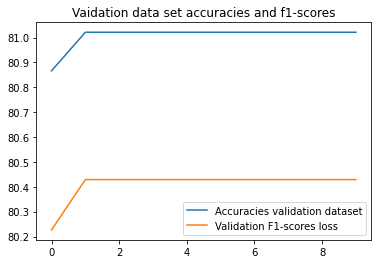

In [ ]:
plt.plot(validation_accuracies, label='Accuracies validation dataset')
plt.plot(F1_scores, label='Validation F1-scores loss')
plt.title('Vaidation data set accuracies and f1-scores')
plt.legend();

In [ ]:
from prettytable import PrettyTable
s = PrettyTable()

In [ ]:
s.field_names = ["Number of iterations", "Validation Set Accuracy%", "F-Scores on validation dataset"]
s.add_row([iterations[0],validation_accuracies[0] ,F1_scores[0]])
s.add_row([iterations[1],validation_accuracies[1] ,F1_scores[1]])
s.add_row([iterations[2],validation_accuracies[2] ,F1_scores[2]])
s.add_row([iterations[3],validation_accuracies[3] ,F1_scores[3]])
s.add_row([iterations[4],validation_accuracies[4] ,F1_scores[4]])
s.add_row([iterations[5],validation_accuracies[5] ,F1_scores[5]])
s.add_row([iterations[6],validation_accuracies[6] ,F1_scores[6]])
s.add_row([iterations[7],validation_accuracies[7] ,F1_scores[7]])
s.add_row([iterations[8],validation_accuracies[8] ,F1_scores[8]])
s.add_row([iterations[9],validation_accuracies[9] ,F1_scores[9]])

In [ ]:
print(s)

+----------------------+--------------------------+--------------------------------+
| Number of iterations | Validation Set Accuracy% | F-Scores on validation dataset |
+----------------------+--------------------------+--------------------------------+
|          5           |    80.86641111248505     |       80.22656445420743        |
|          10          |    81.02166714754819     |       80.42902814274474        |
|          15          |    81.02166714754819     |       80.42902814274474        |
|          20          |    81.02166714754819     |       80.42902814274474        |
|          25          |    81.02166714754819     |       80.42902814274474        |
|          30          |    81.02166714754819     |       80.42902814274474        |
|          35          |    81.02166714754819     |       80.42902814274474        |
|          40          |    81.02166714754819     |       80.42902814274474        |
|          45          |    81.02166714754819     |       80.4290

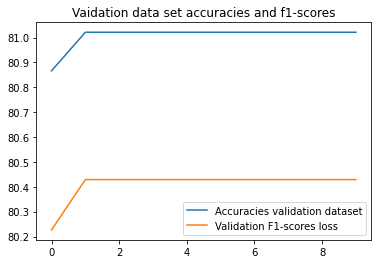

In [ ]:
plt.plot(validation_accuracies, label='Accuracies validation dataset')
plt.plot(F1_scores, label='Validation F1-scores loss')
plt.title('Vaidation data set accuracies and f1-scores')
plt.legend();

#### Observations:
    From the iteration 15 onwards the accuracy remains same and the 
    f1-score also remains same. It depended heavily on the alpha parameter which is 0.000001

## Testing the logistic regression on the `best parameters alpha = 0.000001 and max_iterations=15.`

In [ ]:
clf = SGDClassifier(loss='log',penalty='l2',alpha=0.000001,max_iter=i,random_state=42,learning_rate='optimal')
clf.fit(X_train, y_train)
  

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

#### Validation ACCURACY

In [ ]:
val_score=clf.score(X_valid, y_valid)
val_score

0.8102166714754819

In [ ]:
y_pred=clf.predict(X_valid)

#### Validation f1-score

In [ ]:
f_score=f1_score(y_valid, y_pred, average='weighted')
f_score

0.8042902814274474

#### Accuracy score and f1-score

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.8067149633946318

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.812489180165698

#### Observations:
    Clearly accuracy on the test data has 
    increased to 81.2 percent using best parameters.
    f1-score also increased to 79.33 percent which are bit higher compared to the one given in the paper.

## SVM on Unigrams

In [ ]:
Linear_SV_Classifier = SVC(kernel='linear' )  # linear kernel SVC

In [ ]:
Linear_SV_Classifier.fit(X=X_train[:150000], y=y_train[:150000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Linear_SV_Classifier.score(X_train[:150000],y_train[:150000])

0.8185733333333334

In [ ]:
Linear_SV_Classifier.score(X_valid, y_valid)

0.745119052526002

In [ ]:
y_pred=Linear_SV_Classifier.predict(X_test)

In [ ]:
Linear_SV_Classifier.score(X_test, y_test)

0.74554222826759

## SVM on Bigrams

In [ ]:
Linear_SV_Classifier2 = SVC(kernel='linear' )

In [ ]:
tfv_q1 =TfidfVectorizer(analyzer='word',ngram_range = (1,2))

In [ ]:
from copy import deepcopy

tfv_q2=deepcopy(tfv_q1)

In [ ]:
question1 = tfv_q1.fit_transform(preprocessed_question1)
question2 = tfv_q2.fit_transform(preprocessed_question2)

In [ ]:
labels=target.values
X = scipy.sparse.hstack((question1,question2))
y = labels

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
with open('X_train_bigram', 'wb') as fp:
    pickle.dump(X_train, fp)


with open('X_valid_bigram', 'wb') as fp:
    pickle.dump(X_valid, fp)

with open('X_test_bigram', 'wb') as fp:
    pickle.dump(X_test, fp)


In [ ]:
with open('y_train_bigram', 'wb') as fp:
    pickle.dump(y_train, fp)


with open('y_valid_bigram', 'wb') as fp:
    pickle.dump(y_valid, fp)

with open('y_test_bigram', 'wb') as fp:
    pickle.dump(y_test, fp)


In [ ]:
Linear_SV_Classifier2.fit(X=X_train, y=y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Linear_SV_Classifier2.score(X_train,y_train)

0.822443637773894


In [ ]:
Linear_SV_Classifier2.score(X_valid, y_valid)

0.778851099257601


In [ ]:
y_pred=Linear_SV_Classifier2.predict(X_test)


In [ ]:
Linear_SV_Classifier3.score(X_test, y_test)

0.77974121551781


## SVM on Trigrams

In [ ]:
Linear_SV_Classifier3 = SVC(kernel='linear' )

In [ ]:
tfv_q1 =TfidfVectorizer(analyzer='word',ngram_range = (1,3))

In [ ]:
from copy import deepcopy

tfv_q2=deepcopy(tfv_q1)

In [ ]:
question1 = tfv_q1.fit_transform(preprocessed_question1)
question2 = tfv_q2.fit_transform(preprocessed_question2)

In [ ]:
labels=target.values
X = scipy.sparse.hstack((question1,question2))
y = labels

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
with open('X_train_trigram', 'wb') as fp:
    pickle.dump(X_train, fp)


with open('X_valid_trigram', 'wb') as fp:
    pickle.dump(X_valid, fp)

with open('X_test_trigram', 'wb') as fp:
    pickle.dump(X_test, fp)


In [ ]:
with open('y_train_trigram', 'wb') as fp:
    pickle.dump(y_train, fp)


with open('y_valid_trigram', 'wb') as fp:
    pickle.dump(y_valid, fp)

with open('y_test_trigram', 'wb') as fp:
    pickle.dump(y_test, fp)


In [ ]:
Linear_SV_Classifier3.fit(X=X_train, y=y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Linear_SV_Classifier3.score(X_train,y_train)

0.852443637773894


In [ ]:
Linear_SV_Classifier3.score(X_valid, y_valid)

0.79893351377782


In [ ]:
y_pred=Linear_SV_Classifier3.predict(X_test)


In [ ]:
Linear_SV_Classifier3.score(X_test, y_test)

0.79911353347481


#### Observations:
    From the above experiments with svm it is evident that the accuracies are very similar.
    SVM on trigrams produced greater accuracy which is expected.
    Although it produced better accuracy for trigrams it takes more time to train and accuracy is similar to logistic regression.
    So for this data set Logistic regression is best since it takes only seconds to train and produced high accuracy compared to the SVM.

#  Tree based methods 
    As discussed in the paper tree based method on such high dimesnions is not 
    good since it is computationally intractable to train. So, we will train on 
    new features.

In [ ]:
avg_accuracies=[]
avg_f1_scores=[]

In [ ]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Extracting new features

In [ ]:
q1=df['question1'].values
q2=df['question2'].values

In [ ]:
q1

array(['What is the step by step guide to invest in share market in india?',
       'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
       'How can I increase the speed of my internet connection while using a VPN?',
       ..., 'What is one coin?',
       'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?',
       'What is like to have sex with cousin?'], dtype=object)

In [ ]:
q2

array(['What is the step by step guide to invest in share market?',
       'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
       'How can Internet speed be increased by hacking through DNS?', ...,
       "What's this coin?",
       'I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?',
       'What is it like to have sex with your cousin?'], dtype=object)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontractTree(phrase):

    # specifictext


    phrase = re.sub(r",", " ", phrase)
    phrase = re.sub(r"\.", " ", phrase)
    phrase = re.sub(r"!", " ", phrase)
    phrase = re.sub(r"\(", " ( ", phrase)
    phrase = re.sub(r"\)", " ) ", phrase)
    phrase = re.sub(r"\?", " ", phrase)


    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub("\'ve", " have ", phrase)
    phrase = re.sub(" whats ", " what is ", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub("n't", " not ", phrase)
    phrase = re.sub("i'm", "i am", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub("e\.g\.", " eg ", phrase)
    phrase = re.sub("b\.g\.", " bg ", phrase)
    phrase = re.sub("e-mail", " email ", phrase)
    phrase = re.sub("(\d+)(kK)", " \g<1>000 ", phrase)
    phrase = re.sub("\(s\)", " ", phrase)
    phrase = re.sub("[c-fC-F]\:\/", " disk ", phrase)
    phrase = re.sub('(?<=[0-9])\,(?=[0-9])', "", phrase)  ## removing comma between numbers like 15,000...
    phrase = re.sub('\$', " dollar ", phrase)
    phrase = re.sub('\%', " percent ", phrase)
    phrase = re.sub('\&', " and ", phrase)

    phrase = re.sub("(?<=[0-9])rs ", " rs ", phrase, flags=re.IGNORECASE)
    phrase = re.sub(" rs(?=[0-9])", " rs ", phrase, flags=re.IGNORECASE)

    return phrase

In [ ]:
tree_question1=[]

In [ ]:
import time 
start=time.time()

# tqdm is for printing the status bar
try:
  for sentence in (df['question1'].values):
      encoded_string = sentence.encode("ascii", "ignore")
      sentence = encoded_string.decode()
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
      sentence = decontractTree(sentence)
      #sentence = re.sub("\S*\d\S*", "", sentence).strip()
      #sentence = re.sub('[^A-Za-z]+', ' ', sentence)
      #------------------------------------------------------------------------
      #https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python    #------------------------------------------------------------------------
      sentence =re.sub(r'\b\w\b', ' ', sentence)# To remove single letter words
      sentence=re.sub(r'\s{2,}', ' ', sentence).strip()

      #print(sentence)
      #------------------------------------------------------------------------
      # https://gist.github.com/sebleier/554280
      #sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
      tree_question1.append(sentence.strip())

except TypeError:
  print(sentence)

print(f'time taken for completion of data cleaning is {time.time()-start}')

time taken for completion of data cleaning is 113.15211129188538


In [ ]:
tree_question2=[]

In [ ]:
import time 
start=time.time()

# tqdm is for printing the status bar
try:
  for sentence in (df['question2'].values):
      encoded_string = sentence.encode("ascii", "ignore")
      sentence = encoded_string.decode()
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
      sentence = decontractTree(sentence)
      #sentence = re.sub("\S*\d\S*", "", sentence).strip()
      #sentence = re.sub('[^A-Za-z]+', ' ', sentence)
      #------------------------------------------------------------------------
      #https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python    #------------------------------------------------------------------------
      sentence =re.sub(r'\b\w\b', ' ', sentence)# To remove single letter words
      sentence=re.sub(r'\s{2,}', ' ', sentence).strip()

      #print(sentence)
      #------------------------------------------------------------------------
      # https://gist.github.com/sebleier/554280
      #sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
      tree_question2.append(sentence.strip())

except TypeError:
  print(sentence)

print(f'time taken for completion of data cleaning is {time.time()-start}')

time taken for completion of data cleaning is 112.94103717803955


In [ ]:
features = [0.0]*21

In [ ]:
features

[[], [], [], []]

In [ ]:
len(tree_question1)

404348

In [ ]:


#features = [0.0]*21
Div_factor = 0.0001
STOP_WORDS = stopwords.words('english')

def get_features(q1,q2):
    features = [0.0]*21

    #for i in range(len(preprocessed_question1)):
    q1_tokens =  q1.split()
    q2_tokens =  q2.split()


    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return features

    maxx_length = len(q1_tokens) if len(q1_tokens) >= len(q2_tokens) else len(q2_tokens)

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    ################## L features i.e related to Length ################
    features[0] = len(q1_tokens)
    features[1] = len(q2_tokens)
    features[2] = (abs(len(q1_tokens) - len(q2_tokens)))
    features[3] = (len(q1_tokens) / len(q2_tokens))

    ################## LC number of common Lower cased words  ###############
    lc1 = set([lc for lc in q1_tokens if lc.islower()])
    lc2 = set([lc for lc in q1_tokens if lc.islower()])

    count_lc = len(lc1.intersection(lc2))

    features[4] = count_lc
    features[5] = count_lc//maxx_length ## integer division for better results

    ################## LCXS number of common Lower cased words excluding stopwords ###############

    lcxs1 = set([lc for lc in q1_words if lc.islower()])
    lcxs2 = set([lc for lc in q2_words if lc.islower()])

    count_lcxs = len(lcxs1.intersection(lcxs2))

    features[6] = count_lcxs
    features[7] = count_lcxs//maxx_length ## integer division for better results

    ################## Same Last word  ###############

    features[8] = int(q1_tokens[-1] == q2_tokens[-1]) ## either 0 or 1

    ################## CAP number of common CAPITALISED   ###############

    CAP1 = set([lc for lc in q1_tokens if lc.isupper()])
    CAP2 = set([lc for lc in q1_tokens if lc.isupper()])

    count_cap = len(CAP1.intersection(CAP2))

    features[9] = count_cap
    features[10] = count_cap//maxx_length ## integer division for better results

    ##############  Calculating the prefixes of length 3 to 6 along with their count/maxx_length##############
    count_3 = 0
    count_4 = 0
    count_5 = 0
    count_6 = 0
    for m,n in zip(q1_tokens,q2_tokens):
        if len(m)>=3 and len(n)>=3:
          if m[:3] == n[:3]:
            count_3+=1
          if m[:4] == n[:4]:
            count_4+=1
          if m[:5] == n[:5]:
            count_5+=1
          if m[:6] == n[:6]:
            count_6+=1

    features[11] = count_3
    features[12] = count_3//maxx_length

    features[13] = count_4
    features[14] = count_4//maxx_length

    features[15] = count_5
    features[16] = count_5//maxx_length

    features[17] = count_6
    features[18] = count_6//maxx_length

    ########################### Some Miscellaneous Features ######################

    digits1 = set([d for d in q1_tokens if d.isdigit()])
    digits2 = set([d for d in q2_tokens if d.isdigit()])

    count_digits = len(digits1.intersection(digits2))

    features[19] = 1 if ('not' in q1_tokens) and ('not' in q2_tokens) else 0
    features[20] = 1 if count_digits > 0 else 0

    return np.asarray(features)

    
    

In [ ]:
len(tree_question2)

404348

In [ ]:
features = np.zeros((len(tree_question1),21))

for i in range(len(tree_question2)):

    features[i]= get_features(tree_question1[i],tree_question2[i])




In [ ]:
features.shape

(404348, 21)

In [ ]:
X = features
y= labels

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.10, random_state = 42,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size = 0.20, random_state = 42,shuffle=True)


In [ ]:
type(y)

numpy.ndarray

In [ ]:
X_train.shape

(291130, 21)

In [ ]:
X_train[0].shape

(21,)

## Features set 1
    Length of question1 and length of question2, difference in length 
    l1-l2. Ratio of length l1/l2. Total number of features =4.

    For all the subsequent features sets we will use indexes to extract certain features to train the model

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:4], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:4])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:4],y_train)

0.6356198261944835

In [ ]:
clf.score(X_valid[:,:4], y_valid)

0.6360688622343129

In [ ]:
y_pred=clf.predict(X_test[:,:4])

In [ ]:
clf.score(X_test[:,:4], y_test)

0.6391987139854087

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5593114235699947

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6033384800426743

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6391987139854087

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.94      0.77     25696
           1       0.52      0.12      0.20     14739

    accuracy                           0.64     40435
   macro avg       0.59      0.53      0.48     40435
weighted avg       0.60      0.64      0.56     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:4], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:4])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:4],y_train)

0.6541373269673342

In [ ]:
clf.score(X_valid[:,:4], y_valid)

0.6362199964277373

In [ ]:
y_pred=clf.predict(X_test[:,:4])

In [ ]:
clf.score(X_test[:,:4], y_test)

0.639322369234574

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5687730602828117

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6040922680065125

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.639322369234574

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.92      0.76     25696
           1       0.52      0.15      0.23     14739

    accuracy                           0.64     40435
   macro avg       0.59      0.53      0.50     40435
weighted avg       0.60      0.64      0.57     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:4], y_train)


In [ ]:
clf.predict(X_valid[:,:4])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:4],y_train)

0.6356163913028544

In [ ]:
clf.score(X_valid[:,:4], y_valid)

0.6362199964277373

In [ ]:
y_pred=clf.predict(X_test[:,:4])

In [ ]:
clf.score(X_test[:,:4], y_test)

0.639322369234574

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5687730602828117

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6040922680065125

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.639322369234574

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.92      0.76     25696
           1       0.52      0.15      0.23     14739

    accuracy                           0.64     40435
   macro avg       0.59      0.53      0.50     40435
weighted avg       0.60      0.64      0.57     40435



In [ ]:
avg_accuracies.append((63.9+63.93+63.93)/3)
avg_f1_scores.append((55.93+56.87+56.87)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995]
[56.556666666666665]


#### Observation:
    Accuracy was 63.91 which is bit higher compared to the paper's which is 63.7
    and f1_score in paper is 30.7 which less compared to our model

## New features set 2

    In this additional features such as lower cased common words are included

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:6], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:6])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:6],y_train)

0.6395905609178031

In [ ]:
clf.score(X_valid[:,:6], y_valid)

0.6401220065125098

In [ ]:
y_pred=clf.predict(X_test[:,:6])

In [ ]:
clf.score(X_test[:,:6], y_test)

0.6447137380981822

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5840263470236267

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6151834618313288

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6447137380981822

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.91      0.77     25696
           1       0.54      0.18      0.27     14739

    accuracy                           0.64     40435
   macro avg       0.60      0.55      0.52     40435
weighted avg       0.62      0.64      0.58     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:6], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:6])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:6],y_train)

0.6418953732009756

In [ ]:
clf.score(X_valid[:,:6], y_valid)

0.6400670486239919

In [ ]:
y_pred=clf.predict(X_test[:,:6])

In [ ]:
clf.score(X_test[:,:6], y_test)

0.6444664275998516

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5939808195794176

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6153153770077424

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6444664275998516

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.89      0.76     25696
           1       0.53      0.21      0.30     14739

    accuracy                           0.64     40435
   macro avg       0.60      0.55      0.53     40435
weighted avg       0.62      0.64      0.59     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:6], y_train)


In [ ]:
clf.predict(X_valid[:,:6])

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf.score(X_train[:,:6],y_train)

0.6411156528011541

In [ ]:
clf.score(X_valid[:,:6], y_valid)

0.6395586881552011

In [ ]:
y_pred=clf.predict(X_test[:,:6])

In [ ]:
clf.score(X_test[:,:6], y_test)

0.6431309509088661

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.5902307017331425

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.612856995928997

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6431309509088661

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.90      0.76     25696
           1       0.53      0.20      0.29     14739

    accuracy                           0.64     40435
   macro avg       0.59      0.55      0.53     40435
weighted avg       0.61      0.64      0.59     40435



In [ ]:
avg_accuracies.append((64.47+64.47+63.31)/3)
avg_f1_scores.append((58.40+58.39+59.02)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333]
[56.556666666666665, 58.60333333333333]


#### Observation:
    Accuracy was 64.08 which is bit low  compared to the paper's which is 68.5
    and f1_scores are almost similar

## New Features set 3
    In this we'll include features such as
    Lower cased common words excluding the stop words

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:8], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:8])

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
clf.score(X_train[:,:8],y_train)

0.6763542060247999

In [ ]:
clf.score(X_valid[:,:8], y_valid)

0.6723960265446601

In [ ]:
y_pred=clf.predict(X_test[:,:8])

In [ ]:
clf.score(X_test[:,:8], y_test)

0.6782985037714852

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.6799072672425639

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6819790579228517

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6782985037714852

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     25696
           1       0.56      0.58      0.57     14739

    accuracy                           0.68     40435
   macro avg       0.66      0.66      0.66     40435
weighted avg       0.68      0.68      0.68     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:8], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:8])

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
clf.score(X_train[:,:8],y_train)

0.6947823996152921

In [ ]:
clf.score(X_valid[:,:8], y_valid)

0.6800489125207809

In [ ]:
y_pred=clf.predict(X_test[:,:8])

In [ ]:
clf.score(X_test[:,:8], y_test)

0.6841350315320885

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.683899489615778

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6836726656634287

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6841350315320885

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     25696
           1       0.57      0.56      0.57     14739

    accuracy                           0.68     40435
   macro avg       0.66      0.66      0.66     40435
weighted avg       0.68      0.68      0.68     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:8], y_train)


In [ ]:
clf.predict(X_valid[:,:8])

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
clf.score(X_train[:,:8],y_train)

0.6912822450451688

In [ ]:
clf.score(X_valid[:,:8], y_valid)

0.6776445048981218

In [ ]:
y_pred=clf.predict(X_test[:,:8])

In [ ]:
clf.score(X_test[:,:8], y_test)

0.6830468653394337

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.6834472636675246

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6838740875558004

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.6830468653394337

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     25696
           1       0.56      0.57      0.57     14739

    accuracy                           0.68     40435
   macro avg       0.66      0.66      0.66     40435
weighted avg       0.68      0.68      0.68     40435



In [ ]:
avg_accuracies.append((67.82+68.41+68.30)/3)
avg_f1_scores.append((67.99+68.38+68.34)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333, 68.17666666666666]
[56.556666666666665, 58.60333333333333, 68.23666666666666]


#### Observation:
    Accuracy was 68.17 which is bit higher compared to the paper's which is 70.7
    and f1_score of 68.23 is pretty high compared to the papers which is 63.3

## New Features set 4
    In this we included the additional features which are Last word being same 

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:9], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:9])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:9],y_train)

0.704874111221791

In [ ]:
clf.score(X_valid[:,:9], y_valid)

0.7017847574296195

In [ ]:
y_pred=clf.predict(X_test[:,:9])

In [ ]:
clf.score(X_test[:,:9], y_test)

0.7030542846543836

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7011453703288079

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.6998206681678684

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7030542846543836

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     25696
           1       0.60      0.56      0.58     14739

    accuracy                           0.70     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.70      0.70     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:9], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:9])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:9],y_train)

0.726853982756844

In [ ]:
clf.score(X_valid[:,:9], y_valid)

0.7067447068683621

In [ ]:
y_pred=clf.predict(X_test[:,:9])

In [ ]:
clf.score(X_test[:,:9], y_test)

0.708519846667491

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.703765144982425

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7021576158536033

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.708519846667491

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     25696
           1       0.61      0.54      0.57     14739

    accuracy                           0.71     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.71      0.70     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:9], y_train)


In [ ]:
clf.predict(X_valid[:,:9])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:9],y_train)

0.7199258063408099

In [ ]:
clf.score(X_valid[:,:9], y_valid)

0.7045601307997746

In [ ]:
y_pred=clf.predict(X_test[:,:9])

In [ ]:
clf.score(X_test[:,:9], y_test)

0.7084456535179918

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7037286598907239

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7021140201974122

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7084456535179918

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     25696
           1       0.61      0.54      0.57     14739

    accuracy                           0.71     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.71      0.70     40435



In [ ]:
avg_accuracies.append((70.30+70.85+70.84)/3)
avg_f1_scores.append((70.11+70.37+70.37)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333, 68.17666666666666, 70.66333333333333]
[56.556666666666665, 58.60333333333333, 68.23666666666666, 70.28333333333335]


#### Observation:
    Accuracy was 70.66 which is bit lower compared to the paper's which is 72.7
    and f1_scores of 70.28 is higher compared to the paper which is 63.6 

## New Features Set 5
    In this additional features such as common capitalised words are included

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:11], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:11])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:11],y_train)

0.7056023082471748

In [ ]:
clf.score(X_valid[:,:11], y_valid)

0.7013725732657351

In [ ]:
y_pred=clf.predict(X_test[:,:11])

In [ ]:
clf.score(X_test[:,:11], y_test)

0.7037962161493755

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7019071967938523

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7005945780141817

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7037962161493755

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     25696
           1       0.60      0.57      0.58     14739

    accuracy                           0.70     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.70      0.70     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:11], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:11])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:11],y_train)

0.7304915329921341

In [ ]:
clf.score(X_valid[:,:11], y_valid)

0.7082148303862166

In [ ]:
y_pred=clf.predict(X_test[:,:11])

In [ ]:
clf.score(X_test[:,:11], y_test)

0.7091875850129838

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7052125906160371

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7035534447053328

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7091875850129838

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     25696
           1       0.61      0.55      0.58     14739

    accuracy                           0.71     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.71      0.71     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:11], y_train)


In [ ]:
clf.predict(X_valid[:,:11])

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clf.score(X_train[:,:11],y_train)

0.7217875176038197

In [ ]:
clf.score(X_valid[:,:11], y_valid)

0.7053158017668961

In [ ]:
y_pred=clf.predict(X_test[:,:11])

In [ ]:
clf.score(X_test[:,:11], y_test)

0.7088660813651539

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7048895529280024

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7032245306842533

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7088660813651539

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.80      0.78     25696
           1       0.61      0.55      0.58     14739

    accuracy                           0.71     40435
   macro avg       0.68      0.67      0.68     40435
weighted avg       0.70      0.71      0.70     40435



In [ ]:
avg_accuracies.append((70.37+70.91+70.88)/3)
avg_f1_scores.append((70.19+70.52+70.48)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333, 68.17666666666666, 70.66333333333333, 70.72]
[56.556666666666665, 58.60333333333333, 68.23666666666666, 70.28333333333335, 70.39666666666666]


#### Observation:
    Accuracy was 70.72 which is bit low compared to the paper's which is 72.8
    and f1_score of 70.39 is higher compared to paper's which is 64.5

## New Features set 6
    Additional fetures such as common prefixes of length 3 to 6 are included along with their normalised counts

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train[:,:19], y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid[:,:19])

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
clf.score(X_train[:,:19],y_train)

0.7157558479029986

In [ ]:
clf.score(X_valid[:,:19], y_valid)

0.7115535221136804

In [ ]:
y_pred=clf.predict(X_test[:,:19])

In [ ]:
clf.score(X_test[:,:19], y_test)

0.7145294917769259

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7123544765323677

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7109963760209248

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7145294917769259

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     25696
           1       0.62      0.58      0.60     14739

    accuracy                           0.71     40435
   macro avg       0.69      0.68      0.69     40435
weighted avg       0.71      0.71      0.71     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train[:,:19], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid[:,:19])

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
clf.score(X_train[:,:19],y_train)

0.7584172019372789

In [ ]:
clf.score(X_valid[:,:19], y_valid)

0.7189728370636

In [ ]:
y_pred=clf.predict(X_test[:,:19])

In [ ]:
clf.score(X_test[:,:19], y_test)

0.718733770248547

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7163476935084124

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7149640314407965

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.718733770248547

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78     25696
           1       0.62      0.58      0.60     14739

    accuracy                           0.72     40435
   macro avg       0.70      0.69      0.69     40435
weighted avg       0.71      0.72      0.72     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train[:,:19], y_train)


In [ ]:
clf.predict(X_valid[:,:19])

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
clf.score(X_train[:,:19],y_train)

0.7385291794043898

In [ ]:
clf.score(X_valid[:,:19], y_valid)

0.7189178791750821

In [ ]:
y_pred=clf.predict(X_test[:,:19])

In [ ]:
clf.score(X_test[:,:19], y_test)

0.7207369852850254

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7192725900608978

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7182202786360935

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7207369852850254

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     25696
           1       0.62      0.59      0.61     14739

    accuracy                           0.72     40435
   macro avg       0.70      0.69      0.70     40435
weighted avg       0.72      0.72      0.72     40435



In [ ]:
avg_accuracies.append((71.45+71.87+72.07)/3)
avg_f1_scores.append((71.23+71.63+71.92)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333, 68.17666666666666, 70.66333333333333, 70.72, 71.79666666666667]
[56.556666666666665, 58.60333333333333, 68.23666666666666, 70.28333333333335, 70.39666666666666, 71.59333333333335]


#### Observation:
    Accuracy was 71.79 which is bit low compared to the paper's which is 73.2
    and f1_score of 71.59 is higher compared to paper's which is 64.8

## New Features Set 7
    Some miscellaneous features such as whether both questions contain 
    'not' whether they contain common digit or not

### Applying decision Tree
    All the parameters are as mentioned in the paper.

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,min_samples_leaf=5)

In [ ]:
clf = clf.fit(X_train, y_train)   ## fitting only first four length based features

In [ ]:
clf.predict(X_valid)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
clf.score(X_train,y_train)

0.7193212654140761

In [ ]:
clf.score(X_valid, y_valid)

0.7158402374180785

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7162112031655744

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7155034711157255

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7148944392059609

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7162112031655744

In [ ]:
dt_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78     25696
           1       0.61      0.60      0.61     14739

    accuracy                           0.72     40435
   macro avg       0.69      0.69      0.69     40435
weighted avg       0.71      0.72      0.72     40435



### Random Forest Classifier 

In [ ]:
clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_leaf=5,random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.predict(X_valid)

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
clf.score(X_train,y_train)

0.7600968639439426

In [ ]:
clf.score(X_valid, y_valid)

0.7242762733055796

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7247681464078151

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.722329988162765

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7209884912203139

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7247681464078151

In [ ]:
rf_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79     25696
           1       0.63      0.59      0.61     14739

    accuracy                           0.72     40435
   macro avg       0.70      0.70      0.70     40435
weighted avg       0.72      0.72      0.72     40435



### Gradient boosted tree

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=4, random_state=0)

clf=clf.fit(X_train, y_train)


In [ ]:
clf.predict(X_valid)

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
clf.score(X_train,y_train)

0.7367636451069969

In [ ]:
clf.score(X_valid, y_valid)

0.7246060206366871

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7250896500556449

#### `F1-Score`

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.7231122793469331

#### Precision

In [ ]:
precision_score(y_test, y_pred, average='weighted')

0.7218836495037833

#### `Accuracy`

In [ ]:
accuracy_score(y_test, y_pred)

0.7250896500556449

In [ ]:
gdb_acc=accuracy_score(y_test, y_pred)

#### Classification report 

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79     25696
           1       0.63      0.59      0.61     14739

    accuracy                           0.73     40435
   macro avg       0.70      0.70      0.70     40435
weighted avg       0.72      0.73      0.72     40435



In [ ]:
avg_accuracies.append((71.62+72.47+72.50)/3)
avg_f1_scores.append((71.55+72.23+72.31)/3)

In [ ]:
print(avg_accuracies)
print(avg_f1_scores)

[63.919999999999995, 64.08333333333333, 68.17666666666666, 70.66333333333333, 70.72, 71.79666666666667, 72.19666666666667]
[56.556666666666665, 58.60333333333333, 68.23666666666666, 70.28333333333335, 70.39666666666666, 71.59333333333335, 72.03]


#### Observation:
    Accuracy was 72.19 which is bit low compared to the paper's which is 74.6 and
    f1_score of 72.03 is higher compared to paper's which is 66.3

## Plotting Average accuracies and f1-scores of different feature sets

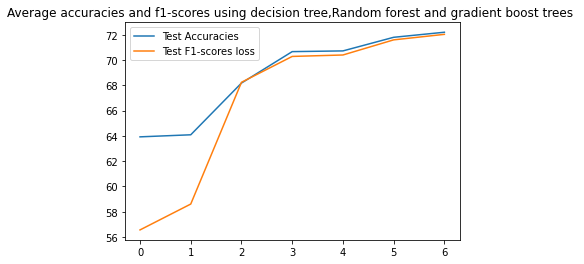

In [ ]:
plt.plot(avg_accuracies, label='Test Accuracies')
plt.plot(avg_f1_scores, label='Test F1-scores loss')
plt.title('Average accuracies and f1-scores using decision tree,Random forest and gradient boost trees ')
plt.legend();

In [ ]:
from prettytable import PrettyTable
z = PrettyTable()

In [ ]:
z.field_names = ["Feature Set", "Average  Accuracy%", "Average F-Scores"]
z.add_row(['L',avg_accuracies[0] ,avg_f1_scores[0]])
z.add_row(['L,LC',avg_accuracies[1] ,avg_f1_scores[1]])
z.add_row(['L,LC,LCXS',avg_accuracies[2] ,avg_f1_scores[2]])
z.add_row(['L,LC,LCXS,LW',avg_accuracies[3] ,avg_f1_scores[3]])
z.add_row(['L,LC,LCXS,LW,CAP',avg_accuracies[4] ,avg_f1_scores[4]])
z.add_row(['L,LC,LCXS,LW,CAP,PRE',avg_accuracies[5] ,avg_f1_scores[5]])
z.add_row(['L,LC,LCXS,LW,CAP,PRE,Misc',avg_accuracies[6] ,avg_f1_scores[6]])

In [ ]:
print(z)

+---------------------------+--------------------+--------------------+
|        Feature Set        | Average  Accuracy% |  Average F-Scores  |
+---------------------------+--------------------+--------------------+
|             L             | 63.919999999999995 | 56.556666666666665 |
|            L,LC           | 64.08333333333333  | 58.60333333333333  |
|         L,LC,LCXS         | 68.17666666666666  | 68.23666666666666  |
|        L,LC,LCXS,LW       | 70.66333333333333  | 70.28333333333335  |
|      L,LC,LCXS,LW,CAP     |       70.72        | 70.39666666666666  |
|    L,LC,LCXS,LW,CAP,PRE   | 71.79666666666667  | 71.59333333333335  |
| L,LC,LCXS,LW,CAP,PRE,Misc | 72.19666666666667  |       72.03        |
+---------------------------+--------------------+--------------------+


# Neural Network Models 


In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,Bidirectional,Activation, BatchNormalization,Flatten,Multiply
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.noise import GaussianNoise
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
from keras.preprocessing import text
from keras.utils import np_utils
from gensim.models import Word2Vec, KeyedVectors 
import gensim

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#### Downloading the GLove 840B 300 dimensions embeddings`
    

In [ ]:
### ' Don't run these cells they are already downloaded and embedding vector was extracted and saved in drive to save time each time.
### So, directly go to the file open embedding vector`

In [ ]:
%cd drive/MyDrive/
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip 

/content/drive/MyDrive
--2022-03-23 05:18:52--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-03-23 05:18:52--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-03-23 05:18:52--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 

##### `Path to save the embeddings and 300d.txt file `
    /content/drive/MyDrive/embedding_vector

In [ ]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
embedding_vector = {}
f = open('glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

2196017it [03:00, 12157.83it/s]


In [ ]:
with open('embedding_vector', 'wb') as fp:
    pickle.dump(embedding_vector, fp)

### Opening already extracted embedding index

In [ ]:
file=open('/content/drive/MyDrive/embedding_vector','rb')
embedding_vector=pickle.load(file)

In [ ]:
embedding_vector

{',': array([-0.082752 ,  0.67204  , -0.14987  , -0.064983 ,  0.056491 ,
         0.40228  ,  0.0027747, -0.3311   , -0.30691  ,  2.0817   ,
         0.031819 ,  0.013643 ,  0.30265  ,  0.0071297, -0.5819   ,
        -0.2774   , -0.062254 ,  1.1451   , -0.24232  ,  0.1235   ,
        -0.12243  ,  0.33152  , -0.006162 , -0.30541  , -0.13057  ,
        -0.054601 ,  0.037083 , -0.070552 ,  0.5893   , -0.30385  ,
         0.2898   , -0.14653  , -0.27052  ,  0.37161  ,  0.32031  ,
        -0.29125  ,  0.0052483, -0.13212  , -0.052736 ,  0.087349 ,
        -0.26668  , -0.16897  ,  0.015162 , -0.0083746, -0.14871  ,
         0.23413  , -0.20719  , -0.091386 ,  0.40075  , -0.17223  ,
         0.18145  ,  0.37586  , -0.28682  ,  0.37289  , -0.16185  ,
         0.18008  ,  0.3032   , -0.13216  ,  0.18352  ,  0.095759 ,
         0.094916 ,  0.008289 ,  0.11761  ,  0.34046  ,  0.03677  ,
        -0.29077  ,  0.058303 , -0.027814 ,  0.082941 ,  0.1862   ,
        -0.031494 ,  0.27985  , -0.074412 ,

## LSTM
    Reference : https://towardsdatascience.com/finding-similar-quora-questions-with-word2vec-and-xgboost-1a19ad272c0d
    https://erogol.com/duplicate-question-detection-deep-learning/
    https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
    https://github.com/aerdem4/kaggle-quora-dup/blob/master/model.py



In [ ]:
def lemmatize(s):
    lemma = []
    wnl = WordNetLemmatizer()
    for doc in s:
        tokens = [wnl.lemmatize(w) for w in doc]
        lemma.append(tokens)

    # Removing Stopwords
    filter_words = []
    Stopwords = set(stopwords.words('english'))

    #ab = spell('nd')
    for sent in lemma:
        tokens = [w for w in sent if w not in Stopwords]
        filter_words.append(tokens)

    space = ' ' 
    sentences = []
    for sentence in filter_words:
        sentences.append(space.join(sentence))
        
    return sentences

In [ ]:
train_que1= list(preprocessed_question1[:int(len(preprocessed_question1)*0.80)])
train_que2= list(preprocessed_question2[:int(len(preprocessed_question2)*0.80)])

test_que1= list(preprocessed_question1[int(len(preprocessed_question1)*0.80):])
test_que2= list(preprocessed_question2[int(len(preprocessed_question2)*0.80):])


In [ ]:
questions = list(preprocessed_question1 + preprocessed_question2)

In [ ]:
questions[:4]

['step step guide invest share market india',
 'story kohinoor koh noor diamond',
 'increase speed internet connection using vpn',
 'mentally lonely solve']

In [ ]:
### MAX_NB_WORDS is a constant which indicates
### the maximum number of words that should be present
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)

In [ ]:
###### converting into sequences and adding padding if the sequence is less than 
###### max length = 30 
train_que1 = tokenizer.texts_to_sequences(train_que1)
train_que1 = pad_sequences(train_que1, maxlen = 30, padding='post')

train_que2 = tokenizer.texts_to_sequences(train_que2)
train_que2 = pad_sequences(train_que2, maxlen = 30, padding='post')


In [ ]:
###### converting into sequences and adding padding if the sequence is less than 
###### max length = 30 
test_que1 = tokenizer.texts_to_sequences(test_que1)
test_que1 = pad_sequences(test_que1, maxlen = 30, padding='post')

test_que2 = tokenizer.texts_to_sequences(test_que2)
test_que2 = pad_sequences(test_que2, maxlen = 30, padding='post')


In [ ]:
print(len(train_que1))
print(len(train_que2))

print(len(test_que1))
print(len(test_que2))

323478
323478
80870
80870


In [ ]:
y_train = labels[:int(len(train_que1))]
y_test  = labels[int(len(train_que1)):]

print(len(y_train))
print(len(y_test))

323478
80870


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

79341


In [ ]:
##### Preparing the embedding matrix that needs to be passed to the sequential model

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    emb_vect = embedding_vector.get(word)
    if emb_vect is not None:
        embedding_matrix[i] = emb_vect

In [ ]:
difference_matrix = train_que1-train_que2

In [ ]:
hadamard_matrix =  train_que1*train_que2

In [ ]:
print(difference_matrix.shape)
print(hadamard_matrix.shape)
print(train_que1.shape)
print(train_que2.shape)
print(test_que1.shape)
print(test_que2.shape)

(323478, 30)
(323478, 30)
(323478, 30)
(323478, 30)
(80870, 30)
(80870, 30)


In [ ]:
#####  Model for training question 1 #######
model_q1 = Sequential()
model_q1.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences = True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'softmax'))

In [ ]:
#####  Model for training question 2 #######
model_q2 = Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'softmax'))

In [ ]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = Multiply()([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'softmax')(mergedOut)

In [ ]:
new_model = Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [ ]:
history = new_model.fit([train_que1,train_que2],y_train, batch_size = 1000, epochs = 10)

Epoch 1/10
324/324 [==============================] - 1410s 4s/step - loss: 0.6601 - accuracy: 0.6282
Epoch 2/10
324/324 [==============================] - 1403s 4s/step - loss: 0.6234 - accuracy: 0.6472
Epoch 3/10
324/324 [==============================] - 1407s 4s/step - loss: 0.5399 - accuracy: 0.7358
Epoch 4/10
324/324 [==============================] - 1404s 4s/step - loss: 0.4959 - accuracy: 0.7612
Epoch 5/10
324/324 [==============================] - 1404s 4s/step - loss: 0.4636 - accuracy: 0.7791
Epoch 6/10
324/324 [==============================] - 1399s 4s/step - loss: 0.4354 - accuracy: 0.7953
Epoch 7/10
324/324 [==============================] - 1400s 4s/step - loss: 0.4103 - accuracy: 0.8099
Epoch 8/10
324/324 [==============================] - 1401s 4s/step - loss: 0.3861 - accuracy: 0.8237
Epoch 9/10
324/324 [==============================] - 1394s 4s/step - loss: 0.3635 - accuracy: 0.8371
Epoch 10/10
324/324 [==============================] - 1401s 4s/step - loss: 0.343

In [ ]:
y_pred = new_model.predict([test_que1, test_que2], batch_size=2000, verbose=1)

41/41 [==============================] - 108s 3s/step


In [ ]:
prediction = []
for i in y_pred:
  if i[0]>i[1]:
    prediction.append(0)
  else:
    prediction.append(1)


In [ ]:
#y_test
from sklearn.metrics import accuracy_score,f1_score
test_accuracy = accuracy_score(y_test, prediction, normalize=True)

In [ ]:
print(f'Test accuracy using LSTM is {test_accuracy*100}')

Test accuracy using continuous bag of words is 75.47916409051564


In [ ]:
F1_score= f1_score(y_test, prediction, average='weighted')

In [ ]:
print(f'Test F1_score using LSTM is {F1_score*100}')

Test F1_score using continuous bag of words is 75.51955653352319


## CBOW

In [ ]:
embedding_vector   ## sample

#### In the paper it was clearly mentioned that the vector representation of each question is sum of embeddings of words of that question 

In [ ]:
embedding_vector['no'].shape   ### getting shape of a random sample

In [ ]:
#########################  For preprocessed question1 #############################

In [ ]:
que1 = [nltk.word_tokenize(sent) for sent in preprocessed_question1]

In [ ]:
import time
start= time.time()

q1_feats = np.zeros((len(que1),300))
for i,question in enumerate(que1):
    #token.fit_on_texts(question)
    #seq = token.texts_to_sequences(question)
    #pad_seq = pad_sequences(seq,maxlen=300)
    
    sent_matrix=np.zeros((1,300),dtype='float32')
    for j,word in enumerate(question):
      embedding_value = embedding_vector.get(word)

      if embedding_value is not None:
          embedding_value=embedding_value.reshape(1,300)
          sent_matrix=np.add(sent_matrix, embedding_value,dtype='float32')
    
    if i% 20000 == 0:
      print(f'time taken for {i} data points is {time.time()-start}')

    q1_feats[i] = sent_matrix
    

time taken for 0 data points is 0.5549523830413818
time taken for 20000 data points is 0.9477851390838623
time taken for 40000 data points is 1.3456008434295654
time taken for 60000 data points is 1.7622265815734863
time taken for 80000 data points is 2.1740288734436035
time taken for 100000 data points is 2.5772078037261963
time taken for 120000 data points is 2.9806816577911377
time taken for 140000 data points is 3.3825554847717285
time taken for 160000 data points is 3.7883799076080322
time taken for 180000 data points is 4.19842529296875
time taken for 200000 data points is 4.596989870071411
time taken for 220000 data points is 5.012941598892212
time taken for 240000 data points is 5.427603006362915
time taken for 260000 data points is 5.8181774616241455
time taken for 280000 data points is 6.217823028564453
time taken for 300000 data points is 6.608186483383179
time taken for 320000 data points is 6.998704433441162
time taken for 340000 data points is 7.401764154434204
time taken

In [ ]:
q1_feats.shape

(404348, 300)

In [ ]:
#########################  For preprocessed question2 #############################

In [ ]:
que2 = [nltk.word_tokenize(sent) for sent in preprocessed_question2]

In [ ]:
import time
start= time.time()

q2_feats = np.zeros((len(que2),300))
for i,question in enumerate(que2):
    #token.fit_on_texts(question)
    #seq = token.texts_to_sequences(question)
    #pad_seq = pad_sequences(seq,maxlen=300)
    
    sent_matrix=np.zeros((1,300),dtype='float32')
    for j,word in enumerate(question):
      embedding_value = embedding_vector.get(word)

      if embedding_value is not None:
          embedding_value=embedding_value.reshape(1,300)
          sent_matrix=np.add(sent_matrix, embedding_value,dtype='float32')
    
    if i% 20000 == 0:
      print(f'time taken for {i} data points is {time.time()-start}')

    q2_feats[i] = sent_matrix

time taken for 0 data points is 0.5762529373168945
time taken for 20000 data points is 0.984105110168457
time taken for 40000 data points is 1.3829340934753418
time taken for 60000 data points is 1.7950999736785889
time taken for 80000 data points is 2.190432071685791
time taken for 100000 data points is 2.608304500579834
time taken for 120000 data points is 3.023306369781494
time taken for 140000 data points is 3.4331719875335693
time taken for 160000 data points is 3.8414981365203857
time taken for 180000 data points is 4.247169494628906
time taken for 200000 data points is 4.643763780593872
time taken for 220000 data points is 5.054635763168335
time taken for 240000 data points is 5.469566583633423
time taken for 260000 data points is 5.8660500049591064
time taken for 280000 data points is 6.273237705230713
time taken for 300000 data points is 6.6884605884552
time taken for 320000 data points is 7.077723026275635
time taken for 340000 data points is 7.496233940124512
time taken for 

In [ ]:
q2_feats.shape

(404348, 300)

In [ ]:
del que1
del que2
del embedding_vector

#### Preparing concatenated matrix

In [ ]:
diff_feats = q1_feats - q2_feats
hadamard_feats = q1_feats * q2_feats

In [ ]:
feat1 = np.hstack((q1_feats,q2_feats))

In [ ]:
del q1_feats 
del q2_feats

In [ ]:
feat2 = np.hstack((diff_feats,hadamard_feats))

In [ ]:
del diff_feats 
del hadamard_feats

In [ ]:
features = np.hstack((feat1,feat2))

In [ ]:
del feat1
del feat2

#### Defining the model
    3 Layer MLP followed by softmax

In [ ]:
model = Sequential()
model.add(Dense(200,input_dim=1200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(2))
model.add(Activation('softmax'))


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
y=labels
X=features 

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(283043, 1200)

In [ ]:
X_test.shape

(121305, 1200)

In [ ]:
with open('CBOW_train', 'wb') as fp:
    pickle.dump(X_train, fp)

with open('CBOW_test', 'wb') as fp:
    pickle.dump(X_test, fp)

with open('CBOW_train_label', 'wb') as fp:
    pickle.dump(y_train, fp)

with open('CBOW_test_label', 'wb') as fp:
    pickle.dump(y_test, fp)

In [ ]:
del features 
del X

In [ ]:
del preprocessed_question1
del preprocessed_question2

In [ ]:
model.fit(X_train,y_train,batch_size=2000,epochs=40)

Epoch 1/40
142/142 [==============================] - 10s 59ms/step - loss: 0.8020 - accuracy: 0.6308
Epoch 2/40
142/142 [==============================] - 8s 59ms/step - loss: 0.4974 - accuracy: 0.7373
Epoch 3/40
142/142 [==============================] - 8s 58ms/step - loss: 0.4577 - accuracy: 0.7642
Epoch 4/40
142/142 [==============================] - 8s 58ms/step - loss: 0.4309 - accuracy: 0.7831
Epoch 5/40
142/142 [==============================] - 8s 58ms/step - loss: 0.4084 - accuracy: 0.7979
Epoch 6/40
142/142 [==============================] - 8s 58ms/step - loss: 0.3871 - accuracy: 0.8128
Epoch 7/40
142/142 [==============================] - 8s 58ms/step - loss: 0.3688 - accuracy: 0.8239
Epoch 8/40
142/142 [==============================] - 8s 58ms/step - loss: 0.3538 - accuracy: 0.8323
Epoch 9/40
142/142 [==============================] - 8s 58ms/step - loss: 0.3378 - accuracy: 0.8407
Epoch 10/40
142/142 [==============================] - 8s 58ms/step - loss: 0.3239 - accur

In [ ]:
predictions = model.predict(X_test,batch_size=200,verbose=1)

607/607 [==============================] - 2s 4ms/step


In [ ]:
predictions

array([[9.57445800e-01, 4.25541773e-02],
       [1.59314454e-01, 8.40685487e-01],
       [6.49681807e-01, 3.50318223e-01],
       ...,
       [1.00000000e+00, 3.75444387e-09],
       [1.06821686e-01, 8.93178284e-01],
       [9.53611970e-01, 4.63880114e-02]], dtype=float32)

In [ ]:
y_pred=[]
for i in predictions:
  if i[0]>i[1]:
    y_pred.append(0)
  else:
    y_pred.append(1)


In [ ]:
#y_test
from sklearn.metrics import accuracy_score,f1_score
test_accuracy = accuracy_score(y_test, y_pred, normalize=True)

In [ ]:
print(f'Test accuracy using continuous bag of words is {test_accuracy*100}')

Test accuracy using continuous bag of words is 80.6166275091711


In [ ]:
F1_score= f1_score(y_test, y_pred, average='weighted')

In [ ]:
print(f'Test F1_score using continuous bag of words is {F1_score*100}')

Test F1_score using continuous bag of words is 80.64197857667455


## References:


1.    https://www.kaggle.com/c/quora-question-pairs
2.   https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30
3. https://towardsdatascience.com/finding-similar-quora-questions-with-bow-tfidf-and-random-forest-c54ad88d1370
4.  https://towardsdatascience.com/finding-similar-quora-questions-with-word2vec-and-xgboost-1a19ad272c0d
5. https://erogol.com/duplicate-question-detection-deep-learning/
6. https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
7. https://github.com/aerdem4/kaggle-quora-dup/blob/master/model.py

